# Ensemble Learning

## Voting Classifiers

`VotingClassifier`: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt

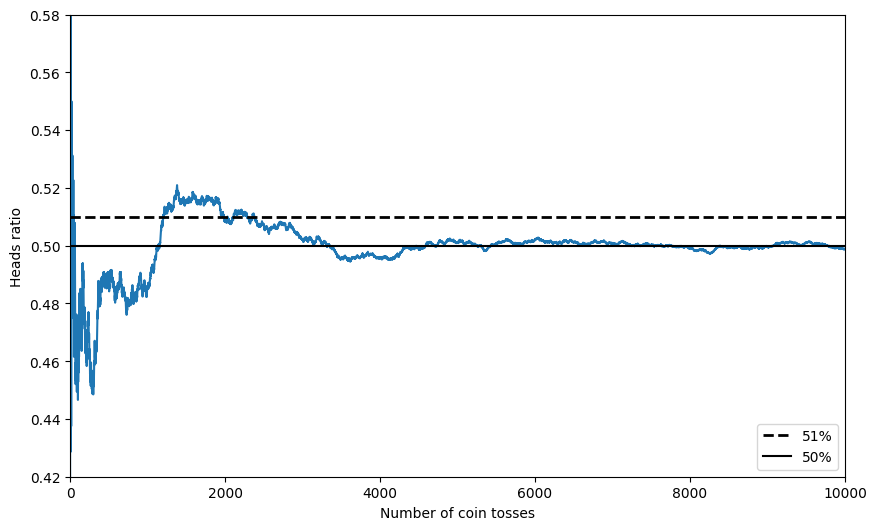

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 1) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)


plt.figure(figsize=(10,6))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

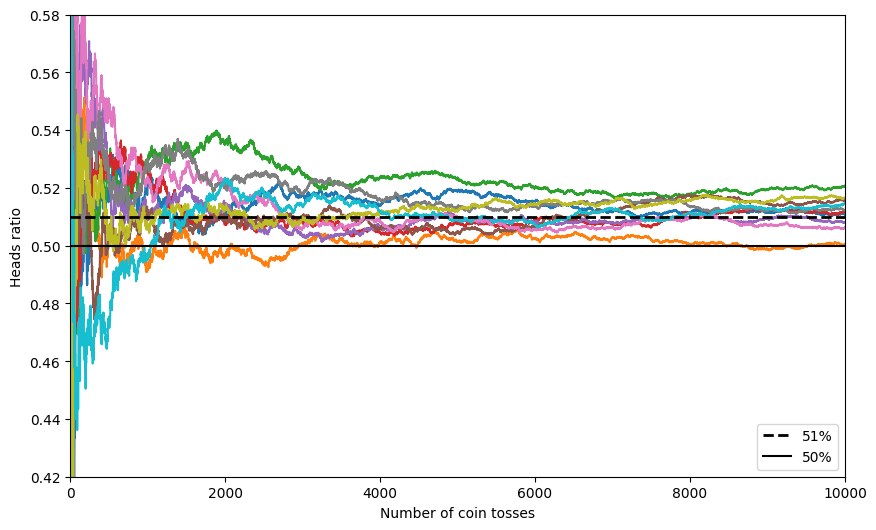

In [3]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)


plt.figure(figsize=(10,6))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

In [4]:
coin_tosses.shape

(10000, 10)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
X.shape, y.shape


((500, 2), (500,))

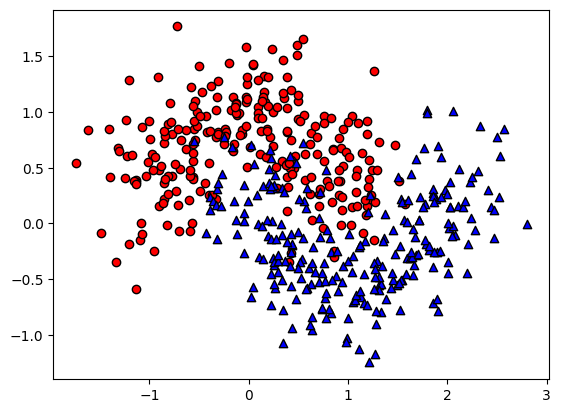

In [7]:
import matplotlib.pyplot as plt

plt.scatter(X[y==0,0],X[y==0,1],c='r',marker='o',edgecolors='black')
plt.scatter(X[y==1,0],X[y==1,1],c='b',marker='^',edgecolors='black')
plt.show()

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

In [9]:
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [10]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

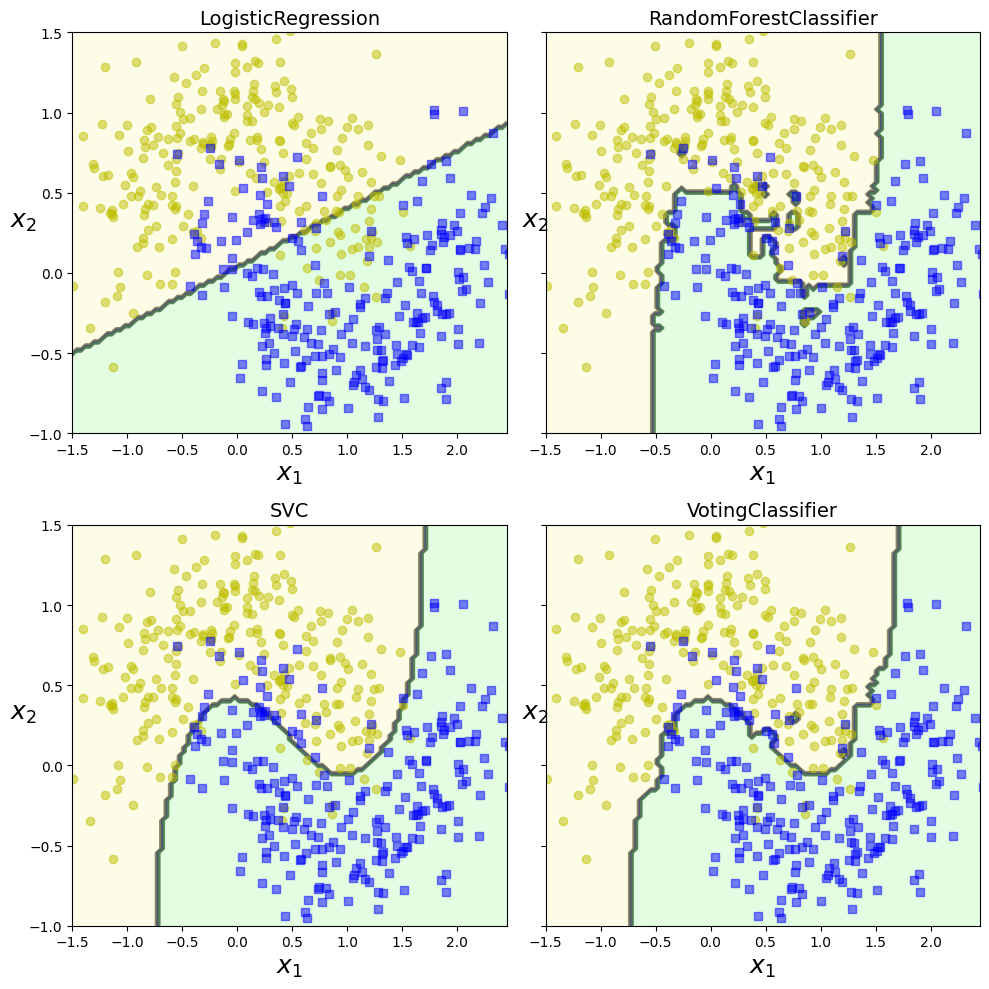

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharey=True)
for idx, clf in enumerate((log_clf, rnd_clf, svm_clf, voting_clf)):
    plt.sca(axes[idx//2][idx%2])
    plot_decision_boundary(clf, X, y)
    plt.title(clf.__class__.__name__, fontsize=14)

plt.tight_layout()
plt.show()

## Bagging

### Bagging Classifier
A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

In [12]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

accuracy_score(y_test, y_pred_tree)

0.856

In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=20,
    max_samples=100, 
    bootstrap=True, 
    random_state=42
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.904

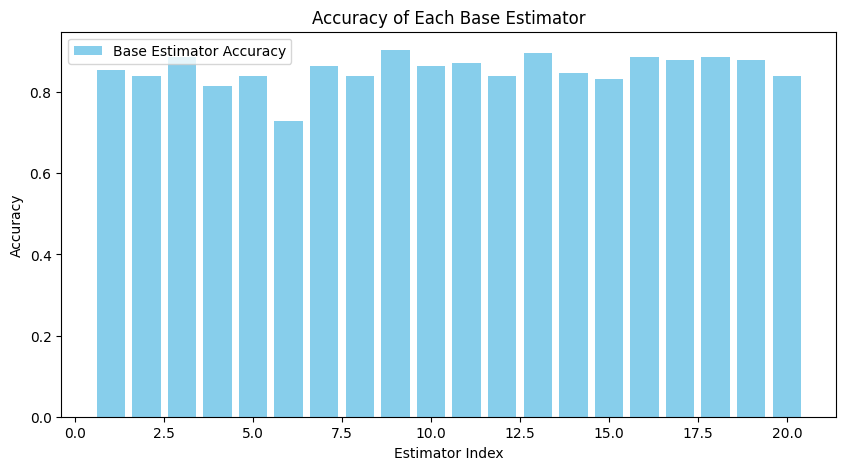

In [14]:
# Get accuracy of each individual estimator
accuracies = []
for estimator in bag_clf.estimators_:
    y_pred = estimator.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(accuracies) + 1), accuracies, color='skyblue', label='Base Estimator Accuracy')
plt.xlabel('Estimator Index')
plt.ylabel('Accuracy')
plt.title('Accuracy of Each Base Estimator')
plt.legend()
plt.show()

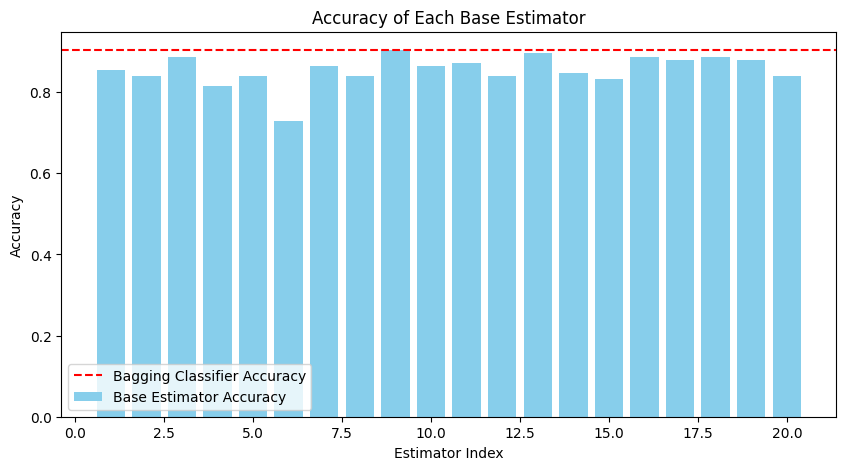

In [15]:
# Get accuracy of each individual estimator
accuracies = []
for estimator in bag_clf.estimators_:
    y_pred = estimator.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(accuracies) + 1), accuracies, color='skyblue', label='Base Estimator Accuracy')
plt.axhline(y=bag_clf.score(X_test, y_test), color='red', linestyle='--', label='Bagging Classifier Accuracy')
plt.xlabel('Estimator Index')
plt.ylabel('Accuracy')
plt.title('Accuracy of Each Base Estimator')
plt.legend(loc='lower left')
plt.show()

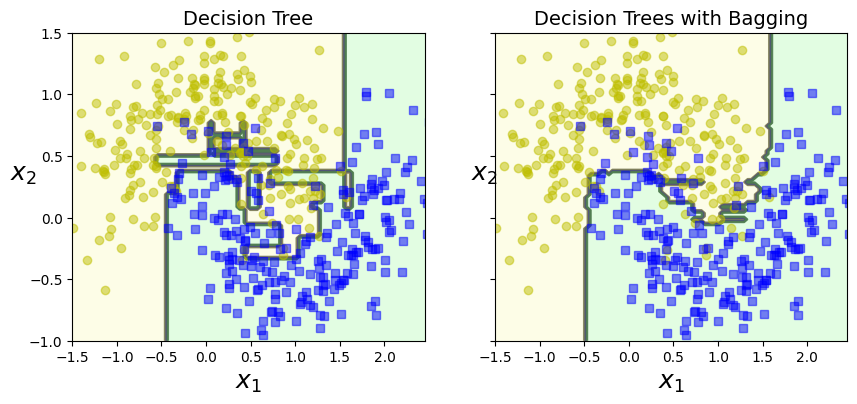

In [16]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

`Ensemble`'s predictions will likely generalize much better (with smaller variance) than a single Decision Tree!

### RandomForest 

`Random Forest` is essentially an extension of Bagging, but with an additional layer of feature randomness.

In [17]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(
    n_estimators=20, 
    max_leaf_nodes=16, 
    max_features="sqrt",
    random_state=42
)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

accuracy_score(y_test, y_pred_rf)

0.904

Let’s say we have **1000 training samples**:
- Each tree gets **1000 samples**, but some are repeated.
- The probability that a specific sample **is not selected** in one draw is:  
  $$
  P(\text{not selected}) = 1 - \frac{1}{N} = 1 - \frac{1}{1000} = 0.999
  $$
- The probability that a sample is **never selected in N draws** is:  
  $$
  (1 - \frac{1}{N})^N \approx e^{-1} \approx 0.3679
  $$
- This means **about 37% of the training data is left out per tree**, forming the **out-of-bag (OOB) samples**.


In [18]:
from sklearn.ensemble import ExtraTreesClassifier

et_clf = ExtraTreesClassifier(
    n_estimators=20, 
    max_leaf_nodes=16, 
    max_features="sqrt",
    random_state=42
)
et_clf.fit(X_train, y_train)

y_pred_et = et_clf.predict(X_test)

accuracy_score(y_test, y_pred_et)

0.896

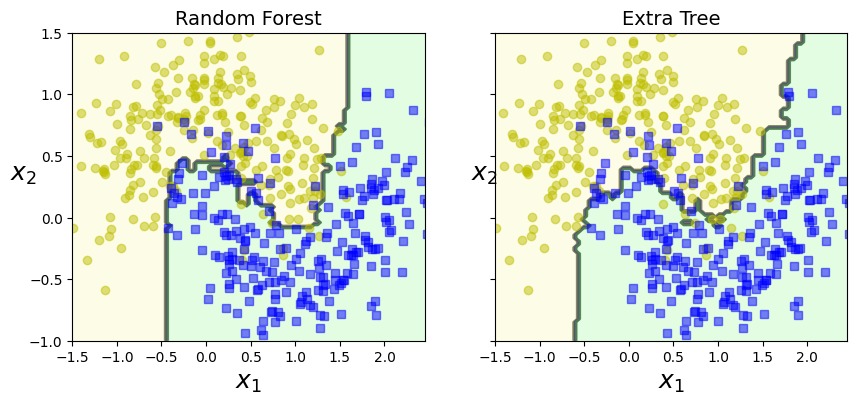

In [19]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(rnd_clf, X, y)
plt.title("Random Forest", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(et_clf, X, y)
plt.title("Extra Tree", fontsize=14)
plt.show()

## Boosting

**Boosting** (originally called hypothesis boosting) refers to any ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor.

### AdaBoost

1
0.5


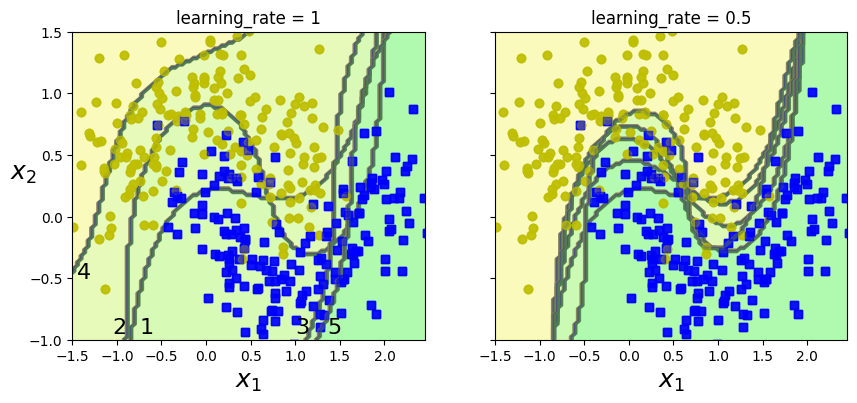

In [20]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    print(learning_rate)
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

plt.show()

In [21]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=20,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

y_pred_ada = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred_ada)

0.88

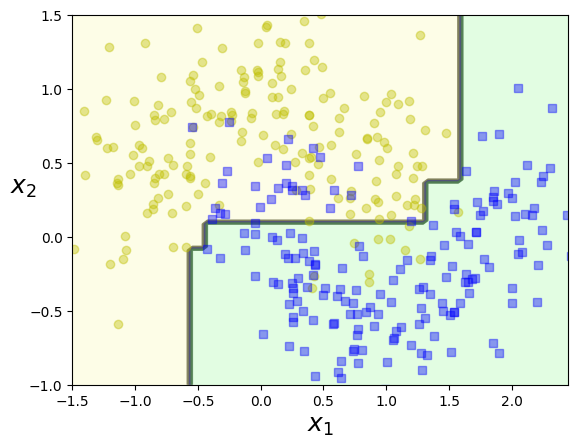

In [22]:
plot_decision_boundary(ada_clf, X_train, y_train, alpha=0.4)

### Gradient Boosting
Just like AdaBoost, gradient boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

In case of a gradient boosting regressor, this yields predictions with the following form:
$$
\hat{y}_i = \sum_{k=1}^{n_{iter}} h_m(x_i)
$$

In [23]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [24]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [25]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [26]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

In [27]:
import matplotlib.pyplot as plt

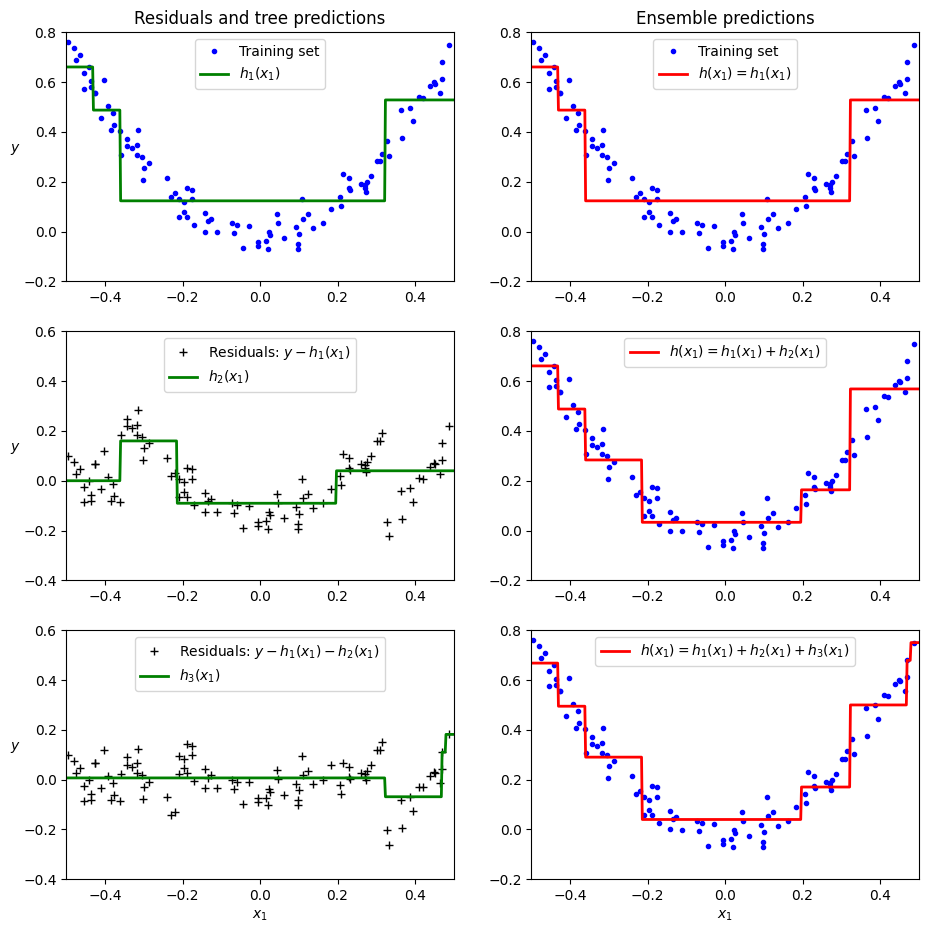

In [28]:
def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")
plt.show()

Directly apply a gradient boosting regressor

In [29]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [30]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [31]:
gbrt_best.n_estimators_

92

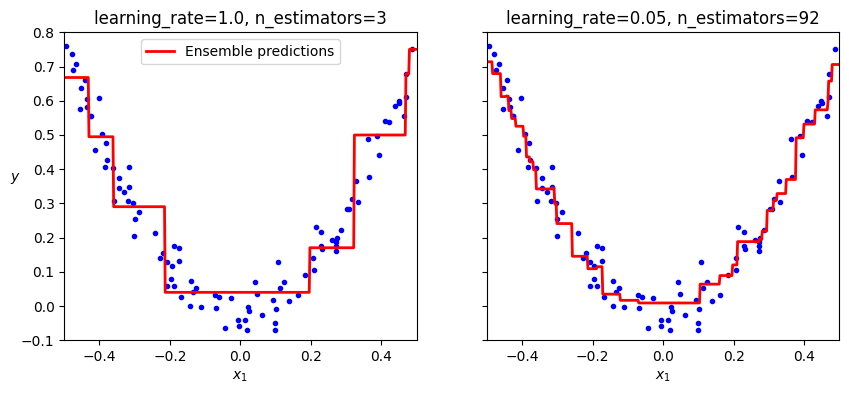

In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")
plt.show()

## Stacking

In [33]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [34]:
stacking_clf.score(X_test,y_test)

0.928

In [37]:
from sklearn.metrics import accuracy_score

# Get individual base estimators
base_models = stacking_clf.estimators_
names = [
    'LogisticRegression',
    'RandomForestRegressor',
    'SupportVectorClassifier'
]

# Evaluate each base model
for name, model in zip(names, base_models):
    y_pred = model.predict(X_test)  # Make predictions
    acc = accuracy_score(y_test, y_pred)  # Compute accuracy
    print(f"Accuracy of {name}: {acc:.4f}")

# Evaluate the final stacked model
stacked_acc = accuracy_score(y_test, stacking_clf.predict(X_test))
print(f"Accuracy of StackingClassifier (Final Model): {stacked_acc:.4f}")

Accuracy of LogisticRegression: 0.8640
Accuracy of RandomForestRegressor: 0.8960
Accuracy of SupportVectorClassifier: 0.8960
Accuracy of StackingClassifier (Final Model): 0.9280
